# Read FCS data to AnnData object

Github Repo: https://github.com/whitews/FlowIO

In [1]:
import os
import re
from warnings import warn

import flowio
import numpy as np
import pandas as pd
from anndata import AnnData

BASE_DIR = os.getcwd()

In [2]:
fcs_data = flowio.FlowData(os.path.join(BASE_DIR, "HTS_BD_LSR_II_Mixed_Specimen_001_D6_D06.fcs"))

In [3]:
data_array = np.reshape(fcs_data.events, (-1, fcs_data.channel_count))

In [4]:
adata = AnnData(X=data_array, uns=fcs_data.text)

# Add channels as varnames
adata.var_names = [item["PnN"] for item in fcs_data.channels.values()]

# Add time channel to obs
adata.obs["time"] = adata[:, "Time"].X.toarray()

In [5]:
fcs_data.channel_count

11

In [6]:
def parse_spill_matrix(fdata: flowio.FlowData) -> pd.DataFrame | None:
    """Parse spill matrix from flow data object."""
    if "spill" not in fdata.text:
        return None

    split_parts = fdata.text["spill"].split(",")
    num = int(split_parts[0])

    _spill_matrix = pd.DataFrame(
        np.reshape(split_parts[num + 1 :], (num, num)).astype(np.float64),
        index=split_parts[1 : num + 1],
        columns=split_parts[1 : num + 1],
    )
    return _spill_matrix


spill_data = parse_spill_matrix(fcs_data)
adata.uns["spill_matrix"] = spill_data
spill_data

,FITC-A,PerCP-Cy5-5-A,AmCyan-A,PE-TxRed YG-A
FITC-A,1.00,0.0,0.022,0.0
PerCP-Cy5-5-A,0.00,1.0,0.000,0.0
AmCyan-A,0.16,0.0,1.000,0.0
PE-TxRed YG-A,0.04,0.0,0.020,1.0


In [7]:
def parse_channel_data(fdata: flowio.FlowData) -> pd.DataFrame | None:
    """Parse channel data from flow data object."""
    dict_list = [{}] * fdata.channel_count

    convert_channel_name = {
        "n": "$PnN",
        "r": "$PnR",
        "b": "$PnB",
        "e": "$PnE",
        "v": "$PnV",
        "g": "$PnG",
        "display": "display",
        "bs": "bs",
        "ms": "ms",
    }

    found_items = 0

    for key, value in fdata.text.items():
        pattern_match = re.match(r"^p(?P<number>[0-9]{1,2})(?P<key>n|r|b|e|v|g|display|bs|ms)$", key)
        if pattern_match is not None:
            found_items += 1
            parsed_dict = pattern_match.groupdict()

            dict_list[int(parsed_dict["number"]) - 1] = {
                **dict_list[int(parsed_dict["number"]) - 1],
                convert_channel_name.get(parsed_dict["key"], parsed_dict["key"]): value,
            }

    if found_items == 0:
        return None
    elif found_items % fdata.channel_count != 0:
        warn("Incomplete channel information.", UserWarning, stacklevel=1)

    return pd.DataFrame(dict_list)


parse_channel_data(fcs_data)

/tmp/ipykernel_16329/79349246.py:33: UserWarning: Incomplete channel information.
  warn("Incomplete channel information.", UserWarning, stacklevel=1)


,$PnN,$PnR,$PnB,$PnE,$PnV,$PnG,display,bs,ms
0,FSC-A,262144,32,"0,0",611,1.0,LOG,-1,0
1,FSC-H,262144,32,"0,0",611,1.0,LOG,-1,0
2,FSC-W,262144,32,"0,0",611,1.0,NaN,-1,0
3,SSC-A,262144,32,"0,0",210,1.0,LOG,-1,0
4,SSC-H,262144,32,"0,0",210,1.0,LOG,-1,0
5,SSC-W,262144,32,"0,0",210,1.0,NaN,-1,0
6,FITC-A,262144,32,"0,0",580,1.0,LOG,-1,0
7,PerCP-Cy5-5-A,262144,32,"0,0",580,1.0,LOG,-1,0
8,AmCyan-A,262144,32,"0,0",550,1.0,LOG,-1,0
9,PE-TxRed YG-A,262144,32,"0,0",500,1.0,LOG,-1,0


In [8]:
adata.var = adata.var.merge(
    right=parse_channel_data(fcs_data),
    left_index=True,
    right_on="$PnN",
    how="right",
).set_index("$PnN")

/tmp/ipykernel_16329/79349246.py:33: UserWarning: Incomplete channel information.
  warn("Incomplete channel information.", UserWarning, stacklevel=1)


In [9]:
adata

AnnData object with n_obs × n_vars = 14945 × 11
    obs: 'time'
    var: '$PnR', '$PnB', '$PnE', '$PnV', '$PnG', 'display', 'bs', 'ms'
    uns: 'beginanalysis', 'endanalysis', 'beginstext', 'endstext', 'begindata', 'enddata', 'fil', 'sys', 'tot', 'par', 'mode', 'byteord', 'datatype', 'nextdata', 'creator', 'tube name', 'src', 'experiment name', 'guid', 'date', 'btim', 'etim', 'cyt', 'cytnum', 'window extension', 'export user name', 'export time', 'op', 'fsc asf', 'autobs', 'inst', 'laser1name', 'laser1delay', 'laser1asf', 'laser2name', 'laser2delay', 'laser2asf', 'laser3name', 'laser3delay', 'laser3asf', 'laser4name', 'laser4delay', 'laser4asf', 'plate name', 'well id', 'plate id', 'timestep', 'spill', 'apply compensation', 'threshold', 'p1n', 'p1r', 'p1b', 'p1e', 'p1v', 'p1g', 'p1display', 'p1bs', 'p1ms', 'p2n', 'p2r', 'p2b', 'p2e', 'p2v', 'p2g', 'p2display', 'p2bs', 'p2ms', 'p3n', 'p3r', 'p3b', 'p3e', 'p3v', 'p3g', 'p3bs', 'p3ms', 'p4n', 'p4r', 'p4b', 'p4e', 'p4v', 'p4g', 'p4display'

### FlowUtils

Github Repo: https://github.com/whitews/FlowUtils

Docs: https://flowutils.readthedocs.io/en/latest/

In [10]:
import flowutils

In [11]:
compensation_matrix, fluoro_list = flowutils.compensate.get_spill(fcs_data.text["spill"])

In [12]:
fluoro_indices = []

for index, value in enumerate(fcs_data.channels.values()):
    if value["PnN"] in fluoro_list:
        # print(value, index)
        fluoro_indices.append(index)

In [13]:
comp_data_array = flowutils.compensate.compensate(data_array, compensation_matrix, fluoro_indices)

In [14]:
channel_names = [item["PnN"] for item in fcs_data.channels.values()]

In [15]:
from anndata_fcs import scatter

In [16]:
comp_df = pd.DataFrame(comp_data_array, columns=channel_names)

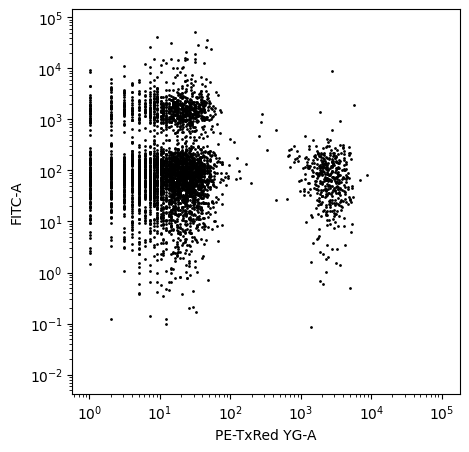

In [17]:
fig, ax = scatter(data=comp_df, x="PE-TxRed YG-A", y="FITC-A")

In [18]:
sum(data_array.flatten() == fcs_data.events) == fcs_data.event_count * fcs_data.channel_count

True

In [19]:
data_array.shape

(14945, 11)